In [1]:
import torch
import torchsummary
from torchsummary import summary
from torchvision import models

import copy
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
import os
import yaml
import json

In [2]:
import socket
if socket.gethostname()[0:4] in  ['node','holm','wats']:
    path_prefix = '/rigel/issa/users/Tahereh/Research'
elif socket.gethostname() == 'SYNPAI':
    path_prefix = '/hdd6gig/Documents/Research'
elif socket.gethostname()[0:2] == 'ax':
    path_prefix = '/home/tt2684/Research'

resultsdir = path_prefix + '/Results/Symbio/Symbio/'

In [3]:
'''
    For the given path, get the List of all files in the directory tree 
'''
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [32]:
all_paths = getListOfFiles(resultsdir)

In [16]:
for p in all_paths:
     if os.path.getsize(p) > 10000000:
            if '.csv' in p or '.json' in p:
                print(os.path.getsize(p), p.split('/')[-2:])
                print(os.remove(p))

In [238]:
# for p in all_paths:
#         if 'autoencoder' in p and '.json' in p:
#             print(os.path.getsize(p), p.split('/')[-2:])
#             print(os.remove(p))

FileNotFoundError: [Errno 2] No such file or directory: '/home/tt2684/Research/Results/Symbio/Symbio/Oct07-11-37_MNIST_8bef0c74ea_RMSpRMSpMNISTAsymResLNet10BNaffine2_200/run_json_dict_autoencoder_FA.json'

## read json results files

In [35]:
import pylab
pylab.rc('font', family='serif', size=12)
def get_measure_dicts_json(hashname_disc, n_epochs_disc):
#     fig, ax = plt.subplots(1,1, figsize=(5,3.5))
    #'RMSpropRMSpropMNISTAsymResLNet10' #'RMSpropRMSpropMNISTFullyConn' ##'RMSpropRMSpropMNISTFullyConnE150'
    # 'RMSpRMSpMNISTAsymResLNet10BNaffine'
    methods = ['SLVanilla','BP', 'FA']
    colors = {'FA':'k', 'BP':'k', 'SLVanilla':'red'}
    linestyles = {'FA':'--', 'BP':'-', 'SLVanilla':'-'}
    if 'AsymResLNet' in hashname:
        markers = {'FA':'o', 'BP':'o', 'SLVanilla':'o'}
    elif 'FullyConn' in hashname:
        markers = {'FA':'s', 'BP':'s', 'SLVanilla':'s'}

    facecolors = {'FA':'none', 'BP':'k', 'SLVanilla':'red'}

    with open(path_prefix + '/Results/Symbio/runswithhash/%s.txt'%hashname_disc) as f:
        Lines = f.readlines() 

    valid_runnames = []
#     fig, ax = plt.subplots(1,1, figsize=(12,8))
    for l in Lines:
        runname = l.strip('\n')

        configs = yaml.safe_load(open(resultsdir + '/%s/configs.yml'%runname, 'r'))
        list_json_paths = []
        for method in methods:
            p = resultsdir + '/%s/run_json_dict_%s.json'%(runname, method)
            if os.path.exists(p):
                
                with open(p,"r") as jfile:
                    dj = json.load(jfile)
                
                if len(dj['Test_acce']) >= n_epochs_disc: #configs['epochs']:
                    list_json_paths.append(p)
                else:
                    print(len(dj['Test_acce']),n_epochs_disc, configs['epochs'])
                    
        
        if len(list_json_paths) == len(methods):
            valid_runnames.append(runname)
            configs = yaml.safe_load(open(resultsdir + '/%s/configs.yml'%runname, 'r'))
        else:
            print(list_json_paths)

    print('number of valid runs discriminative',len(valid_runnames))

#     n_pochs = 370 #configs['epochs']
    arch =  configs['arche'][:-1]

    test_init = np.zeros((len(valid_runnames),n_epochs_disc))
    test_acc_dict = {}
    test_corrd_dict = {}
    test_lossd_dict = {}
    for method in methods:
        test_acc_dict[method] = copy.deepcopy(test_init)
        test_corrd_dict[method] = copy.deepcopy(test_init)
        test_lossd_dict[method] = copy.deepcopy(test_init)

    for r, runname in enumerate(valid_runnames):
        configs = yaml.safe_load(open(path_prefix + '/Results/Symbio/Symbio/%s/configs.yml'%runname, 'r'))

        for method in methods:
            p = resultsdir + '%s/run_json_dict_%s.json'%(runname, method)
            with open(p,"r") as jfile:
                dj = json.load(jfile)
            label = method 
#             ax.plot(dj['lrF'], label=label, color=colors[method], ls=linestyles[method])
            test_acc_dict[method][r] = dj['Test_acce'][0:n_epochs_disc]
            test_corrd_dict[method][r] = dj['Test_corrd'][0:n_epochs_disc]
            test_lossd_dict[method][r] = dj['Test_lossd'][0:n_epochs_disc]
    return test_acc_dict, test_corrd_dict, test_lossd_dict, configs




def get_measure_dicts_ae_json(hashname_ae, n_epochs_ae):
    #'RMSpropRMSpropMNISTAsymResLNet10' #'RMSpropRMSpropMNISTFullyConn' ##'RMSpropRMSpropMNISTFullyConnE150'
    # 'RMSpRMSpMNISTAsymResLNet10BNaffine'
#     fig, ax = plt.subplots(1,1, figsize=(5,3.5))
    methods = ['BP', 'FA']
    colors = {'FA':'k', 'BP':'k'}
    linestyles = {'FA':'--', 'BP':'-'}

    with open(path_prefix + '/Results/Symbio/runswithhash/%s.txt'%hashname_ae) as f:
        Lines = f.readlines() 

    valid_runnames = []
#     fig, ax = plt.subplots(1,1, figsize=(12,8))
    for l in Lines:
        runname = l.strip('\n')

        configs = yaml.safe_load(open(resultsdir + '/%s/configs.yml'%runname, 'r'))
        list_json_paths = []
        for method in methods:
            p = resultsdir + '/%s/run_json_dict_autoencoder_%s.json'%(runname, method)
            if os.path.exists(p):
                
                with open(p,"r") as jfile:
                    dj = json.load(jfile)
                
                if len(dj['Test_acce']) >= n_epochs_ae: #configs['epochs']:
                    list_json_paths.append(p)
                else:
                    print('auto',len(dj['Test_acce']), n_epochs_ae, configs['epochs'])
                    
        
        if len(list_json_paths) == len(methods):
            valid_runnames.append(runname)
            configs = yaml.safe_load(open(path_prefix + '/Results/Symbio/Symbio/%s/configs.yml'%runname, 'r'))

    print('number of valid runs autoencoder',len(valid_runnames))

#     n_pochs = 370 #configs['epochs']
    arch =  configs['arche'][:-1]

    test_init = np.zeros((len(valid_runnames),n_epochs_ae))
    test_acc_dict = {}
    test_corrd_dict = {}
    test_lossd_dict = {}
    for method in methods:
        test_acc_dict[method] = copy.deepcopy(test_init)
        test_corrd_dict[method] = copy.deepcopy(test_init)
        test_lossd_dict[method] = copy.deepcopy(test_init)

    for r, runname in enumerate(valid_runnames):
        configs = yaml.safe_load(open(resultsdir + '/%s/configs.yml'%runname, 'r'))

        for method in methods:
            p = resultsdir + '/%s/run_json_dict_autoencoder_%s.json'%(runname, method)
            with open(p,"r") as jfile:
                dj = json.load(jfile)
            label = method 
#             ax.plot(dj['lrF'], label=label, color=colors[method], ls=linestyles[method])
            test_acc_dict[method][r] = dj['Test_acce'][0:n_epochs_ae]
            test_corrd_dict[method][r] = dj['Test_corrd'][0:n_epochs_ae]
            test_lossd_dict[method][r] = dj['Test_lossd'][0:n_epochs_ae]
            if method == 'FA' and np.all(test_corrd_dict[method][r]<0.9):
                print('inja',runname, len(dj['Test_corrd']))
    return test_acc_dict, test_corrd_dict, test_lossd_dict, configs









In [37]:
#'RMSpropRMSpropMNISTAsymResLNet10' #'RMSpropRMSpropMNISTFullyConn' ##'RMSpropRMSpropMNISTFullyConnE150'
    # 'RMSpRMSpMNISTAsymResLNet10BNaffine'
    
hashname=  'RMSpropRMSpropMNISTFullyConnE150' #'RMSpRMSpMNISTAsymResLNet10BNaffine2' #'RMSpropRMSpropMNISTFullyConnE150' #'RMSpRMSpMNISTAsymResLNet10BNaffine2'



#****MNIST****
# 'RMSpRMSpMNISTAsymResLNet10BNaffine2'
# 'RMSpRMSpMNISTAsymResLNet10BNaff3'

#****CIFAR10*******
#'RMSpCIFAR10AsymResLNet10BNaff'

#***'Fashion MNIST****'
#'RMSpRMSpFaMNISTAsymResLNet10BNaff' # 'RMSpRMSpFaMNISTAsymResLNet10BNaffPtnc30' #'FaMNISTAsymResLNet10BNaff' 

#'MNISTAsymResLNet10BNaffPatience30'
#'RMSpRMSpFaMNISTAsymResLNet10BNaffPtnc30' #'RMSpRMSpMNISTAsymResLNet10BNaff3' # #'RMSpRMSpMNISTAsymResLNet10BNaff3' #'RMSpRMSpMNISTAsymResLNet10BNaffine2'
#'RMSpRMSpFaMNISTAsymResLNet10BNaffPtnc30'#'RMSpRMSpFaMNISTAsymResLNet10BNaff' #'RMSpCIFAR10AsymResLNet10BNaff'     #'FaMNISTAsymResLNet10BNaff' #'RMSpRMSpMNISTAsymResLNet10BNaff3'


#'RMSpRMSpFaMNISTAsymResLNet10BNaff' # 'RMSpRMSpMNISTAsymResLNet10BNaffine'
#'RMSpRMSpFaMNISTAsymResLNet10BNaff' #'RMSpRMSpMNISTAsymResLNet10BNaffine'
n_epochs = 150
n_epochs_ae = 150
test_acc_dict, test_corrd_dict, test_lossd_dict, configs = get_measure_dicts_json(hashname, n_epochs)
test_acc_dict_ae, test_corrd_dict_ae, test_lossd_dict_ae, configs = get_measure_dicts_ae_json(hashname, n_epochs_ae)

number of valid runs discriminative 24
auto 106 150 150
auto 99 150 150
auto 109 150 150
auto 110 150 150
auto 96 150 150
auto 109 150 150
auto 70 150 150
auto 109 150 150
auto 58 150 150
auto 70 150 150
auto 10 150 150
auto 12 150 150
auto 11 150 150
auto 13 150 150
auto 11 150 150
auto 11 150 150
auto 12 150 150
auto 7 150 150
auto 14 150 150
auto 6 150 150
auto 12 150 150
auto 6 150 150
number of valid runs autoencoder 13
inja Oct02-21-28_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_827 150
inja Oct02-21-28_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_916 150
inja Oct02-21-28_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_469 150
inja Oct02-21-28_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_913 150
inja Oct02-21-28_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_486 150
inja Oct02-21-29_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_109 150
inja Oct02-21-29_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_955 150
inja Oct02-21-29_MNIST_e6507d0d57_RMSpropRMSpr

164 200 200
['/home/tt2684/Research/Results/Symbio/Symbio//Oct07-11-36_MNIST_8bef0c74ea_RMSpRMSpMNISTAsymResLNet10BNaffine2_252/run_json_dict_BP.json', '/home/tt2684/Research/Results/Symbio/Symbio//Oct07-11-36_MNIST_8bef0c74ea_RMSpRMSpMNISTAsymResLNet10BNaffine2_252/run_json_dict_FA.json']
152 200 200
['/home/tt2684/Research/Results/Symbio/Symbio//Oct07-11-37_MNIST_8bef0c74ea_RMSpRMSpMNISTAsymResLNet10BNaffine2_594/run_json_dict_BP.json', '/home/tt2684/Research/Results/Symbio/Symbio//Oct07-11-37_MNIST_8bef0c74ea_RMSpRMSpMNISTAsymResLNet10BNaffine2_594/run_json_dict_FA.json']
143 200 200
['/home/tt2684/Research/Results/Symbio/Symbio//Oct07-11-37_MNIST_8bef0c74ea_RMSpRMSpMNISTAsymResLNet10BNaffine2_272/run_json_dict_BP.json', '/home/tt2684/Research/Results/Symbio/Symbio//Oct07-11-37_MNIST_8bef0c74ea_RMSpRMSpMNISTAsymResLNet10BNaffine2_272/run_json_dict_FA.json']
127 200 200
['/home/tt2684/Research/Results/Symbio/Symbio//Oct07-11-37_MNIST_8bef0c74ea_RMSpRMSpMNISTAsymResLNet10BNaffine2_796

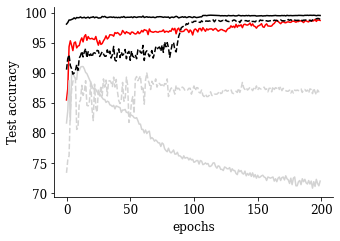

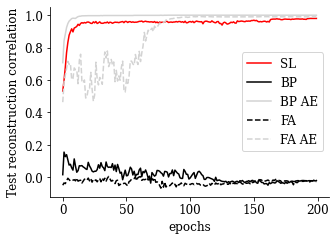

In [77]:

hashname= 'RMSpRMSpMNISTAsymResLNet10BNaffine2' #'RMSpRMSpMNISTAsymResLNet10BNaffine2'


# 'MNISTAsymResLNet10BNaffPatience30'
#'RMSpRMSpMNISTAsymResLNet10BNaff3'

#'RMSpCIFAR10AsymResLNet10BNaff'


#'RMSpRMSpFaMNISTAsymResLNet10BNaff'  'RMSpRMSpFaMNISTAsymResLNet10BNaffPtnc30' #'FaMNISTAsymResLNet10BNaff' 


#'RMSpRMSpFaMNISTAsymResLNet10BNaffPtnc30' #'RMSpRMSpMNISTAsymResLNet10BNaff3' #'RMSpRMSpMNISTAsymResLNet10BNaffine'
#'RMSpRMSpFaMNISTAsymResLNet10BNaff' #'RMSpRMSpMNISTAsymResLNet10BNaff3' #'RMSpRMSpFaMNISTAsymResLNet10BNaff' # 'RMSpRMSpMNISTAsymResLNet10BNaffine' 
n_epochs = 200#300#800#200#300#370
n_epochs_ae = 200#300#500#200#300

#'RMSpropRMSpropMNISTAsymResLNet10' #'RMSpropRMSpropMNISTFullyConn' ##'RMSpropRMSpropMNISTFullyConnE150'
    # 'RMSpRMSpMNISTAsymResLNet10BNaffine'
    #'RMSpRMSpMNISTAsymResLNet10BNaffine'




test_acc_dict, test_corrd_dict, test_lossd_dict, configs = get_measure_dicts_json(hashname, n_epochs)
test_acc_dict_ae, test_corrd_dict_ae, test_lossd_dict_ae, configs = get_measure_dicts_ae_json(hashname, n_epochs_ae)

arch =  configs['arche'][:-1]

methods = ['SLVanilla', 'BP','FA']
colors = {'FA':'k', 'BP':'k', 'SLVanilla':'red'}
method_labels = {'FA':'FA', 'BP':'BP', 'SLVanilla':'SL'}
linestyles = {'FA':'--', 'BP':'-', 'SLVanilla':'-'}

# Test Acc
fig, ax = plt.subplots(1,1, figsize=(5,3.5))
for method in methods:
    # plot discriminative
    measure = test_acc_dict
    ax.plot(range(n_epochs ), np.median(measure[method], 0), colors[method], label=method_labels[method], ls=linestyles[method])
#     ax.fill_between(range(n_epochs ), np.median(measure[method], 0)-measure[method].std(0),
#                     np.median(measure[method], 0)+measure[method].std(0),
#                     alpha=0.1, color=colors[method], ls=linestyles[method])
    print('method',method, max(np.median(measure[method],0)))
    
    if method in ['FA','BP']:
        # plot autoencoders
        measure = test_acc_dict_ae
        ax.plot(range(n_epochs_ae ), np.median(measure[method], 0), 'lightgray', label=method_labels[method] + ' AE', ls=linestyles[method])
#         ax.fill_between(range(n_epochs ), np.median(measure[method], 0)-measure[method].std(0),
#                         np.median(measure[method], 0)+measure[method].std(0),
#                         alpha=0.1, color='gray', ls=linestyles[method])
        print('autoencoder acc',method, max(np.median(measure[method],0)))
        
    
ax = plt.gca()
ax.patch.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(axis='y',direction='out', right=False)
plt.tick_params(axis='x',direction='out', top=False)
ax.set_xlabel('epochs')
ax.set_ylabel('Test accuracy')
# ax.legend(loc='center right')

# ax.set_title('%s %s (%s)'%(configs['dataset'], arch, hashname))

savedir = path_prefix + '/Results/Symbio/runswithhash/%s/'%hashname
if not os.path.exists(savedir):
    os.makedirs(savedir)

fig.savefig(savedir + '5lineplots_Testacc_%s.png'%(hashname), dpi=200)
fig.savefig(savedir + '5lineplots_Testacc_%s.pdf'%(hashname), dpi=200)


# ax.set_title('Convolutional architecture on %s'%configs['dataset'])


savedir = path_prefix + '/Results/Symbio/runswithhash/Final/'
if not os.path.exists(savedir):
    os.makedirs(savedir)
    
fig.savefig(savedir + '5lineplots_Testacc_%s.png'%(hashname), dpi=200)
fig.savefig(savedir + '5lineplots_Testacc_%s.pdf'%(hashname), dpi=200)
#-------------------------------------------------------------------------------

# Test correlation
fig, ax = plt.subplots(1,1, figsize=(5,3.5))
for method in methods:
    # plot discriminative
    measure = test_corrd_dict
    ax.plot(range(n_epochs ), np.median(measure[method], 0), colors[method], label=method_labels[method], ls=linestyles[method])
#     ax.fill_between(range(n_epochs ), np.median(measure[method], 0)-measure[method].std(0),
#                     np.median(measure[method], 0)+measure[method].std(0),
#                     alpha=0.1, color=colors[method], ls=linestyles[method])
    print('method',method, max(np.median(measure[method],0)))
    
    if method in ['FA','BP']:
        # plot autoencoders
        measure = test_corrd_dict_ae
        ax.plot(range(n_epochs_ae ), np.median(measure[method], 0), 'lightgray', label=method_labels[method] + ' AE', ls=linestyles[method])
#         ax.fill_between(range(n_epochs ), np.median(measure[method], 0)-measure[method].std(0),
#                         np.median(measure[method], 0)+measure[method].std(0),
#                         alpha=0.1, color='gray', ls=linestyles[method])
        print('autoencoder corr',method, max(np.median(measure[method],0)))
        
    
ax = plt.gca()
ax.patch.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(axis='y',direction='out', right=False)
plt.tick_params(axis='x',direction='out', top=False)
ax.set_xlabel('epochs')
ax.set_ylabel('Test reconstruction correlation')
ax.legend(loc='center right')

# ax.set_title('%s %s (%s)'%(configs['dataset'], arch, hashname))
# plt.tight_layout()

savedir = path_prefix + '/Results/Symbio/runswithhash/%s/'%hashname
if not os.path.exists(savedir):
    os.makedirs(savedir)
    
fig.savefig(savedir + '5lineplots_Testcorrd_%s.png'%(hashname), dpi=200)
fig.savefig(savedir + '5lineplots_Testcorrd_%s.pdf'%(hashname), dpi=200)


# ax.set_title('Convolutional architecture on %s'%configs['dataset'])



savedir = path_prefix + '/Results/Symbio/runswithhash/Final/'
if not os.path.exists(savedir):
    os.makedirs(savedir)
    
fig.savefig(savedir + '5lineplots_Testcorrd_%s.png'%(hashname), dpi=200)
fig.savefig(savedir + '5lineplots_Testcorrd_%s.pdf'%(hashname), dpi=200)
print(hashname, 'PatienceF:',configs['patiencee'],'PatienceB:',configs['patienced'])

# Scatters using jsons

[]
[]
[]
[]
[]
[]
[]
[]
[]
number of valid runs discriminative 10
auto 20 200 200
auto 20 200 200
auto 18 200 200
auto 11 200 200
number of valid runs autoencoder 10
Convolutional
RMSpRMSpMNISTAsymResLNet10BNaffine
number of valid runs discriminative 24
auto 93 100 150
auto 79 100 150
auto 93 100 150
auto 10 100 150
auto 12 100 150
auto 11 100 150
auto 13 100 150
auto 11 100 150
auto 11 100 150
auto 12 100 150
auto 7 100 150
auto 14 100 150
auto 6 100 150
auto 12 100 150
auto 6 100 150
number of valid runs autoencoder 16
inja Oct02-21-25_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_874 134
inja Oct02-21-25_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_829 146
inja Oct02-21-26_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_306 145
inja Oct02-21-28_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_827 150
inja Oct02-21-28_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_916 150
inja Oct02-21-28_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_469 150
inja Oct02-21-28_MNIST_

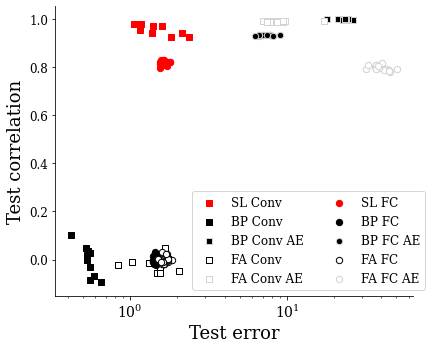

In [64]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

markers = {'FullyConnected':'o', 'Convolutional':'s'}

hash_conv = 'RMSpRMSpMNISTAsymResLNet10BNaffine' #'RMSpRMSpMNISTAsymResLNet10BNaff3' #'RMSpRMSpMNISTAsymResLNet10BNaffine' #'RMSpRMSpMNISTAsymResLNet10BNaff3' #'RMSpRMSpMNISTAsymResLNet10BNaffine2' #'RMSpRMSpMNISTAsymResLNet10BNaffine' #
hash_fc  = 'RMSpropRMSpropMNISTFullyConnE150'



fig, ax = plt.subplots(1,1, figsize=(6,5))

for arch_type in ['Convolutional', 'FullyConnected']:
    colors = {'FA':'k', 'BP':'k', 'SLVanilla':'red'}
    facecolors = {'FA':'white', 'BP':'k', 'SLVanilla':'red'}
    linestyles = {'FA':'--', 'BP':'-', 'SLVanilla':'-'}

    methods = ['SLVanilla', 'BP','FA']
    method_labels = {'FA':'FA', 'BP':'BP', 'SLVanilla':'SL'}
    #'RMSpropRMSpropMNISTAsymResLNet10' #'RMSpropRMSpropMNISTFullyConn' ##'RMSpropRMSpropMNISTFullyConnE150'
        # 'RMSpRMSpMNISTAsymResLNet10BNaffine'
    if arch_type =='Convolutional':
        hash_arch_type = hash_conv
        n_epochs, n_epochs_ae = 200, 200
        arch_label = 'Conv'
    elif arch_type == 'FullyConnected':
        hash_arch_type = hash_fc 
        n_epochs, n_epochs_ae = 150, 100
        arch_label = 'FC'
    test_acc_dict, test_corrd_dict, test_lossd_dict, configs = get_measure_dicts_json(hash_arch_type, n_epochs)
    test_acc_dict_ae, test_corrd_dict_ae, test_lossd_dict_ae, _ = get_measure_dicts_ae_json(hash_arch_type, n_epochs_ae)


#     fig, ax = plt.subplots(1,1, figsize=(5,5))

    for method in methods:
               
        x = 100-test_acc_dict[method][:,-1] #.max(1)#
        y = test_corrd_dict[method][:,-1] #.max(1)
        ax.scatter(x, y, s=40, edgecolor=colors[method],facecolor=facecolors[method],
                   marker=markers[arch_type], label='%s %s'%(method_labels[method],arch_label))
#         confidence_ellipse(x, y, ax, edgecolor=colors[method], ls=linestyles[method])


        if method !='SLVanilla':


            y = test_corrd_dict_ae[method][:,-1] #.max(1)#
            x = 100-test_acc_dict_ae[method][:,-1]#.max(1)

            ax.scatter(x, y, s=40, edgecolor='lightgray', facecolor=facecolors[method],
                       marker=markers[arch_type], label='%s %s'%(method_labels[method],arch_label) + ' AE')
#             confidence_ellipse(x, y, ax, edgecolor='lightgray', ls=linestyles[method])




    ax = plt.gca()
    ax.patch.set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tick_params(axis='y',direction='out', right=False)
    plt.tick_params(axis='x',direction='out', top=False)
    ax.set_xlabel('Test error', fontsize=18)
    ax.set_ylabel('Test correlation', fontsize=18)
#     ax.set_title('%s %s'%(arch_type, configs['dataset']))
    plt.tight_layout()


    plt.xscale('log')
#     plt.yscale('log')
#     plt.grid(True, which="both", ls="-", color='lightblue')
    # plt.gca().invert_xaxis()

    
    print(arch_type)
    print(hash_arch_type)

ax.legend(loc='lower right',bbox_to_anchor=(1.05, 0),ncol=2, )#labelspacing=0.05
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)


savedir = path_prefix + '/Results/Symbio/runswithhash/Final/'
if not os.path.exists(savedir):
    os.makedirs(savedir)
fig.savefig(savedir + 'cloudscatter_wAE_both_%s_%s.png'%(hash_conv, hash_fc), dpi=200)
fig.savefig(savedir + 'cloudscatter_wAE_both_%s_%s.pdf'%(hash_conv, hash_fc), dpi=200)



In [90]:
test_corrd_dict_ae[method][:,-1]

array([0.991, 0.99 , 0.991, 0.991, 0.992, 0.991, 0.992, 0.99 , 0.99 ,
       0.99 ])

In [91]:
test_corrd_dict_ae[method].max(1)

array([0.994, 0.994, 0.994, 0.994, 0.995, 0.994, 0.995, 0.994, 0.995,
       0.994])

In [66]:
#https://matplotlib.org/3.3.1/gallery/statistics/confidence_ellipse.html#sphx-glr-gallery-statistics-confidence-ellipse-py
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    
    return ax.add_patch(ellipse)

## Autoencoders

3


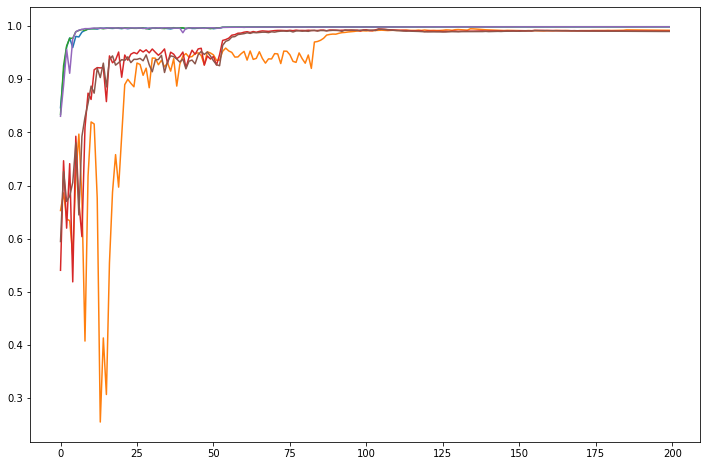

In [12]:
hashname = 'RMSpRMSpMNISTAsymResLNet10BNaffine'
#'RMSpropRMSpropMNISTAsymResLNet10' #'RMSpropRMSpropMNISTAsymResLNet10' #'RMSpropRMSpropMNISTFullyConn' ##'RMSpropRMSpropMNISTFullyConnE150'
methods = ['BP', 'FA']
colors_ae = {'FA':'gray', 'BP':'k'}
linestyles_ae = {'FA':'--', 'BP':'-'}

with open(path_prefix + '/Results/Symbio/runswithhash/%s.txt'%hashname) as f:
    Lines = f.readlines() 

valid_runnames = []
fig, ax = plt.subplots(1,1, figsize=(12,8))
for l in Lines:
    runname = l.strip('\n')
    
    configs = yaml.safe_load(open(path_prefix + '/Results/Symbio/Symbio/%s/configs.yml'%runname, 'r'))
    list_csv_paths = []
    for method in methods:
        p = path_prefix + '/Results/Symbio/Symbio/%s/training_results_autoencoders_%s.csv'%(runname, method)
        if os.path.exists(p):
            df = pd.read_csv(p)
            if len(list(df['test_acc'])) == configs['epochs']:
                list_csv_paths.append(p)
    if len(list_csv_paths) == len(methods):
        valid_runnames.append(runname)
        configs = yaml.safe_load(open(path_prefix + '/Results/Symbio/Symbio/%s/configs.yml'%runname, 'r'))

print(len(valid_runnames))

n_epochs = configs['epochs']
arch =  configs['arche'][:-1]

test_init = np.zeros((len(valid_runnames), n_epochs))
test_acc_dict = {}
test_corrd_dict = {}
test_lossd_dict = {}
for method in methods:
    test_acc_dict[method] = copy.deepcopy(test_init)
    test_corrd_dict[method] = copy.deepcopy(test_init)
    test_lossd_dict[method] = copy.deepcopy(test_init)
    
for r, runname in enumerate(valid_runnames):
    configs = yaml.safe_load(open(path_prefix + '/Results/Symbio/Symbio/%s/configs.yml'%runname, 'r'))
    
    for method in methods:
        p = path_prefix + '/Results/Symbio/Symbio/%s/training_results_autoencoders_%s.csv'%(runname, method)
        df = pd.read_csv(p)
        label = method 
        pl = ax.plot(df['test_corrd'], label=label)
        test_acc_dict[method][r] = list(df['test_acc'])
        test_corrd_dict[method][r] = list(df['test_corrd'])
        test_lossd_dict[method][r] = list(df['test_lossd'])
        

In [274]:
test_acc_dict['BP'].max(1)

array([95.312, 96.094, 95.703, 95.703, 96.484, 95.312, 95.703, 96.094,
       95.703, 94.922])

BP 72.0705
FA 85.8725


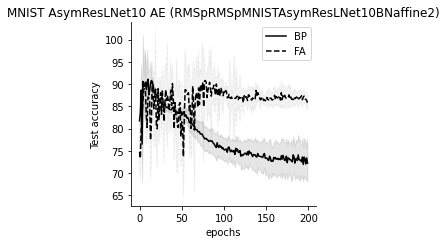

In [116]:
fig, ax = plt.subplots(1,1, figsize=(5,3.5))
measure = test_acc_dict
for method in methods:
    ax.plot(range(n_epochs ), np.median(measure[method], 0), colors[method], label=method, ls=linestyles[method])
    ax.fill_between(range(n_epochs ), np.median(measure[method], 0)-measure[method].std(0),
                    np.median(measure[method], 0)+measure[method].std(0),
                    alpha=0.1, color=colors_ae[method], ls=linestyles_ae[method])
    print(method, measure[method].mean(0)[-1])
    
ax.legend()
ax = plt.gca()
ax.patch.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(axis='y', direction='out', right=False)
plt.tick_params(axis='x', direction='out', top=False)
ax.set_xlabel('epochs')
ax.set_ylabel('Test accuracy')
# ax.set_ylim([95,99])

ax.set_title('%s %s AE (%s)'%(configs['dataset'], arch, hashname))
plt.tight_layout()

# fig.savefig(path_prefix + '/Results/Symbio/runswithhash/%s_test_acc_%s_autoencoders.png'%(hashname, arch), dpi=200)
# fig.savefig(path_prefix + '/Results/Symbio/runswithhash/%s_test_acc_%s_autoencoders.pdf'%(hashname, arch), dpi=200)



BP 0.9989162003784848
FA 0.9894073542795684


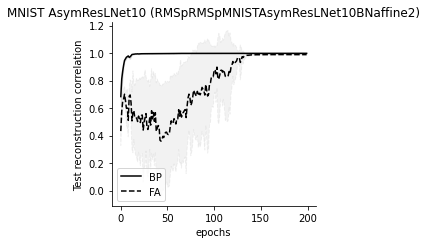

In [118]:
fig, ax = plt.subplots(1,1, figsize=(5,3.5))
measure = test_corrd_dict
for method in methods:
    ax.plot(range(n_epochs ), measure[method].mean(0), colors[method], label=method, ls=linestyles[method])
    ax.fill_between(range(n_epochs ), measure[method].mean(0)-measure[method].std(0),
                    measure[method].mean(0)+measure[method].std(0),
                    alpha=0.1, color=colors_ae[method], ls=linestyles_ae[method])
    print(method, measure[method].mean(0)[-1])
    
ax.legend()
ax = plt.gca()
ax.patch.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(axis='y',direction='out', right=False)
plt.tick_params(axis='x',direction='out', top=False)
ax.set_xlabel('epochs')
ax.set_ylabel('Test reconstruction correlation')

ax.set_title('%s %s (%s)'%(configs['dataset'], arch, hashname))
plt.tight_layout()
# fig.savefig(path_prefix + '/Results/Symbio/runswithhash/%s_test_corrd_%s_autoencoders.png'%(hashname, arch), dpi=200)
# fig.savefig(path_prefix + '/Results/Symbio/runswithhash/%s_test_corrd_%s_autoencoders.pdf'%(hashname, arch), dpi=200)

In [ ]:
getListOfFiles

## Evaluations

In [81]:
import json
import pandas as pd
# def get_evaluation_dicts(hashname):
#'RMSpropRMSpropMNISTAsymResLNet10' #'RMSpropRMSpropMNISTFullyConn' ##'RMSpropRMSpropMNISTFullyConnE150'
# 'RMSpRMSpMNISTAsymResLNet10BNaffine'
hashname=   'RMSpRMSpMNISTAsymResLNet10BNaffine'#'RMSpRMSpMNISTAsymResLNet10BNaffine' #'RMSpRMSpMNISTAsymResLNet10BNaff3'
# 'RMSpRMSpFaMNISTAsymResLNet10BNaffPtnc30'
# 'RMSpropRMSpropMNISTAsymResLNet10'
measure_key = 'Test_corrd'  #'Test_corrd' # 'Test_acce' ##'Test_acce' #'Test_corrd' #'Test_acce'
measure_name = 'correlation' #'correlation'# 'accuracy' # 'accuracy' # 'correlation'# 'accuracy'
# BP_eval2020-10-07_05-57_maxitr4_epsilon0.0e+00_noisesigma20.1.json

methods = ['SLVanilla','BP', 'FA']
colors = {'FA':'k', 'BP':'k', 'SLVanilla':'red'}
linestyles = {'FA':'--', 'BP':'-', 'SLVanilla':'-'}
if 'AsymResLNet' in hashname:
    markers = {'FA':'o', 'BP':'o', 'SLVanilla':'o'}
elif 'FullyConn' in hashname:
    markers = {'FA':'s', 'BP':'s', 'SLVanilla':'s'}

facecolors = {'FA':'none', 'BP':'k', 'SLVanilla':'red'}
method_labels = {'FA':'FA', 'BP':'BP', 'SLVanilla':'SL'}


with open(path_prefix + '/Results/Symbio/runswithhash/%s.txt'%hashname) as f:
    Lines = f.readlines() 

valid_runnames = {}
valid_runnames_autoencoder = {}
valid_runnames_dynamic = {}


master_df = pd.DataFrame()
master_df_autoencoder = pd.DataFrame()
master_df_dynamic = pd.DataFrame()
for l in Lines:
    
    runname = l.strip('\n')
    columns = ['method', 'epsilon','sigma', 'itr0','itr1','itr2','itr3']
    
    
    configs = yaml.safe_load(open(resultsdir + '%s/configs.yml'%runname, 'r'))
    list_csv_paths = []
#     print(path_prefix + '/Results/Symbio/Symbio/%s/evaluate/'%runname)
    if os.path.exists(resultsdir + '%s/evaluate/'%runname):
        df = pd.DataFrame()
        df_autoencoder = pd.DataFrame()
        df_dynamic = pd.DataFrame()
        list_files = getListOfFiles(resultsdir + '%s/evaluate/'%runname)
        list_files = [l for l in list_files if '.json' in l]
        for l in list_files:
            
            fname = l.split('evaluate/')[1]

            
            with open(l, "r") as jfile:
                try:
                    d = json.load(jfile)
                except UnicodeDecodeError:
                    print(l)
                    d = json.load(jfile)
                    
            if ('autoencoder' not in l) and ('dynamicdecoder' not in l):

                df2 = pd.DataFrame({'method': d['method'],
                         'epsilon':[d['eval_epsilon']],
                         'sigma2':[d['eval_sigma2']],
                         'itr0': [d[measure_key][0]],
                         'itr1': [d[measure_key][1]],
                         'itr2': [d[measure_key][2]],
                         'itr3': [d[measure_key][3]]})
                df = df.append(df2, ignore_index=True)
            elif 'autoencoder' in l:
                df2_autoencoder = pd.DataFrame({'method': d['method'],
                         'epsilon':[d['eval_epsilon']],
                         'sigma2':[d['eval_sigma2']],
                         'itr0': [d[measure_key][0]],
                         'itr1': [d[measure_key][1]],
                         'itr2': [d[measure_key][2]],
                         'itr3': [d[measure_key][3]]})
                df_autoencoder = df_autoencoder.append(df2_autoencoder, ignore_index=True)
            elif 'dynamicdecoder' in l:
      
                df2_dynamic = pd.DataFrame({'method': d['method'],
                         'epsilon':[d['eval_epsilon']],
                         'sigma2':[d['eval_sigma2']],
                         'itr0': [d[measure_key][0]],
                         'itr1': [d[measure_key][1]],
                         'itr2': [d[measure_key][2]],
                         'itr3': [d[measure_key][3]]})
                df_dynamic = df_dynamic.append(df2_dynamic, ignore_index=True)
        #if df is not empty
        if len(df.columns)>0:
            
            if np.all([m in list(df['method']) for m in methods]):
                valid_runnames[runname] = runname
                master_df = master_df.append(df)
        # if there are autoencoder runs
        if len(df_autoencoder.columns)>0:
            if np.all([m in list(df_autoencoder['method']) for m in ['FA','BP']]):
                valid_runnames_autoencoder[runname] = runname
                master_df_autoencoder = master_df_autoencoder.append(df_autoencoder)
               # if there are autoencoder runs
        if len(df_dynamic.columns)>0:
            if np.all([m in list(df_dynamic['method']) for m in ['FA','BP']]):
                valid_runnames_dynamic[runname] = runname
                master_df_dynamic = master_df_dynamic.append(df_dynamic)
        del d

    
print('number of valid runs',len(valid_runnames))
print('number of valid autoencoder runs',len(valid_runnames_autoencoder))
print('number of valid dynamic runs',len(valid_runnames_dynamic))


number of valid runs 10
number of valid autoencoder runs 11
number of valid dynamic runs 10


In [51]:
print(l)

Oct06-10-51_MNIST_8bef0c74ea_RMSpRMSpMNISTAsymResLNet10BNaffine_954



In [74]:
np.unique(master_df_autoencoder['method'])

array(['BP', 'FA', 'SLVanilla'], dtype=object)

In [60]:
np.unique(master_df_dynamic['method'])

array(['BP', 'FA'], dtype=object)

## Noise (sigma2)

RMSpRMSpMNISTAsymResLNet10BNaffine correlation


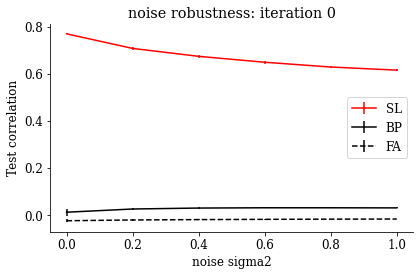

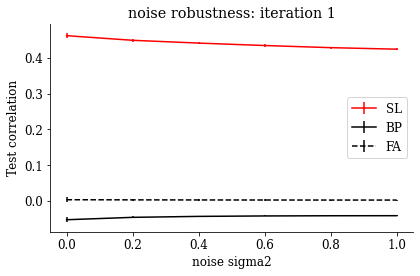

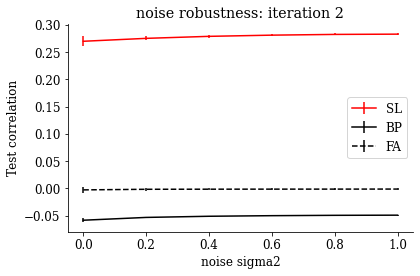

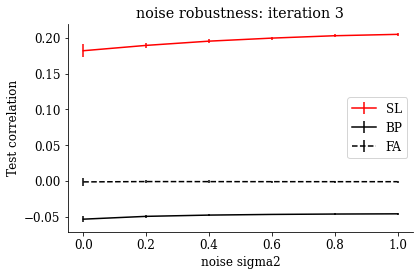

In [82]:
import scipy.stats as ss
 #'BP'#'FA' #'SLVanilla'
facecolors = {'FA':'white', 'SLVanilla':'red', 'BP':'k'}
colors = {'FA':'k', 'BP':'k', 'SLVanilla':'red'}
colors_ae = {'FA':'lightgray', 'BP':'lightgray', 'SLVanilla':'lightcoral'}
sigmas = np.unique(master_df['sigma2'])
_, bins = np.histogram(sigmas,5)
sigmas = np.floor(bins*10)/10

for iteration in range(4):
    fig, ax = plt.subplots(1,1)
    for method in ['SLVanilla','BP','FA']:
    
        
        itr_means, itr_sems = [], []
        for j, s in enumerate(sigmas):
            mehtod_selection = master_df['method']==method
            epsilon_selection = master_df['epsilon']==0.0
            sigma2_selection = (master_df['sigma2']-s)<0.01
            itr = master_df[(mehtod_selection & epsilon_selection )& sigma2_selection]['itr%d'%iteration]
    #         ax.bar(j,itr.mean(), edgecolor=colors[method], color = facecolors[method])
    #         ax.errorbar(j,itr.mean(), ss.sem(itr), color='k' )
            itr_means.append(itr.mean())
            itr_sems.append(ss.sem(itr))
        ax.errorbar(sigmas,itr_means, itr_sems, label=method_labels[method], color=colors[method], ls=linestyles[method])
        
#         if measure_name == 'accuracy':
#             ax.set_ylim([0,100])
#         else:
#             ax.set_ylim([0,0.8])
        #-----autoencoders
#         if method in ['FA','BP']:
#         itr_means, itr_sems = [], []
#         for j, s in enumerate(sigmas):
#             method_selection = master_df_autoencoder['method']==method
#             epsilon_selection = master_df_autoencoder['epsilon']==0.0
#             sigma2_selection = (master_df_autoencoder['sigma2']-s)<0.01
#             itr = master_df_autoencoder[(method_selection & epsilon_selection )& sigma2_selection]['itr%d'%iteration]
#     #         ax.bar(j,itr.mean(), edgecolor=colors[method], color = facecolors[method])
#     #         ax.errorbar(j,itr.mean(), ss.sem(itr), color='k' )
#             itr_means.append(itr.mean())
#             itr_sems.append(ss.sem(itr))
#         ax.errorbar(sigmas,itr_means, itr_sems, label=method_labels[method]+' AE', color=colors_ae[method], ls=linestyles[method])


        ax = plt.gca()
        ax.patch.set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.tick_params(axis='y',direction='out', right=False)
        plt.tick_params(axis='x',direction='out', top=False)
    #     ax.set_xticks(range(len(sigmas)))
    #     ax.set_xticklabels(sigmas)
        ax.set_xlabel('noise sigma2')
        ax.set_ylabel('Test %s'%measure_name)
#         if measure_name == 'accuracy':
#             ax.text(1.1, 1, hashname, fontsize=8, rotation=90)

        ax.set_title('noise robustness: iteration %d'%(iteration))
        ax.legend()
        plt.tight_layout()

    savedir = path_prefix + '/Results/Symbio/runswithhash/%s/evaluate/'%hashname
    if not os.path.exists(savedir):
        os.makedirs(savedir)
    fig.savefig(savedir + 'noise_itr%d_%s.png'%(iteration, measure_name), dpi=200)
    fig.savefig(savedir + 'noise_itr%d_%s.pdf'%(iteration, measure_name), dpi=200)

print(hashname, measure_name)

## Epsilon (adversarial attack)

RMSpRMSpMNISTAsymResLNet10BNaffine correlation


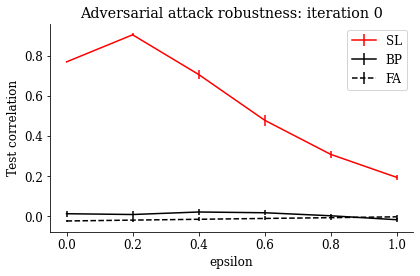

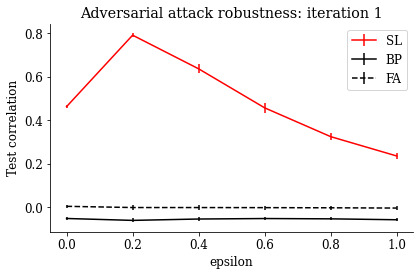

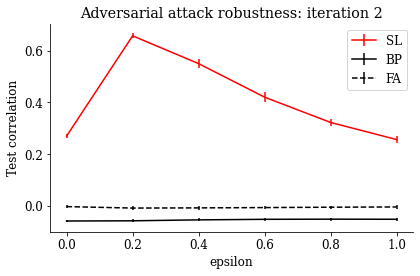

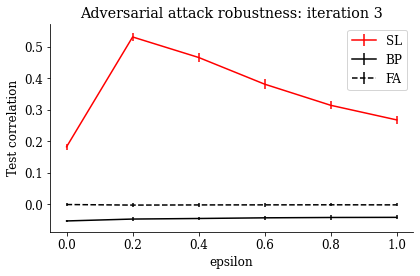

In [83]:
method = 'FA' #'BP'#'FA' #'SLVanilla'
facecolors = {'FA':'white', 'SLVanilla':'red', 'BP':'k'}

epsilons = np.unique(master_df['epsilon'])



for iteration in range(4):
    fig, ax = plt.subplots(1,1)
    for method in ['SLVanilla','BP','FA']:
    
        
        itr_means, itr_sems = [], []
        for j, eps in enumerate(epsilons):
            mehtod_selection = master_df['method']==method
            epsilon_selection = master_df['epsilon']==eps
            sigma2_selection = (master_df['sigma2']-0.0)<0.01
            itr = master_df[(mehtod_selection & epsilon_selection )& sigma2_selection]['itr%d'%iteration]
            itr_means.append(itr.mean())
            itr_sems.append(ss.sem(itr))
            
        ax.errorbar(epsilons,itr_means, itr_sems, label=method_labels[method], color=colors[method], ls=linestyles[method])

#         if measure_name == 'accuracy':
#             ax.set_ylim([0,100])
#         else:
#             ax.set_ylim([0,0.9])

        ax = plt.gca()
        ax.patch.set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.tick_params(axis='y',direction='out', right=False)
        plt.tick_params(axis='x',direction='out', top=False)

        ax.set_xlabel('epsilon')
        ax.set_ylabel('Test %s'%measure_name)
#         if measure_name == 'accuracy':
#             ax.text(1.1, 1, hashname, fontsize=8, rotation=90)
        ax.set_title('Adversarial attack robustness: iteration %d'%(iteration))
        ax.legend()
        plt.tight_layout()

    savedir = path_prefix + '/Results/Symbio/runswithhash/%s/evaluate/'%hashname
    if not os.path.exists(savedir):
        os.makedirs(savedir)
    fig.savefig(savedir + 'advattack_itr%d_%s.png'%(iteration, measure_name), dpi=200)
    fig.savefig(savedir + 'advattack_itr%d_%s.pdf'%(iteration, measure_name), dpi=200)
    
print(hashname, measure_name)

## Recurrence for noise

### with autoencoders

RMSpRMSpMNISTAsymResLNet10BNaffine correlation


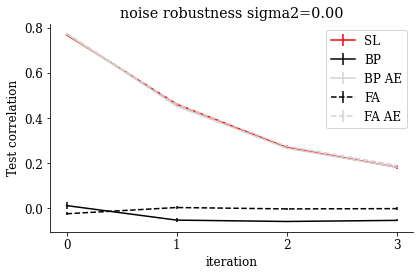

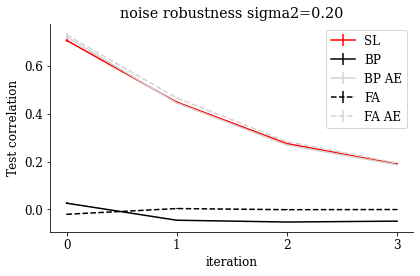

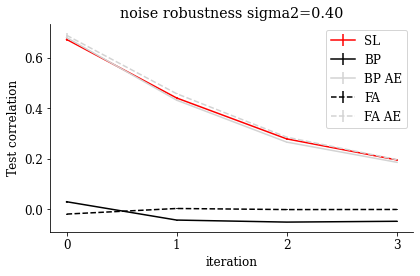

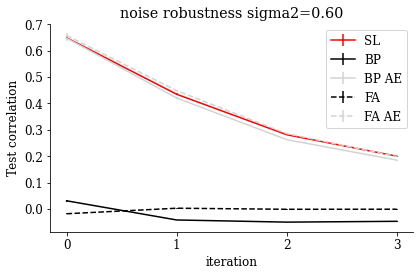

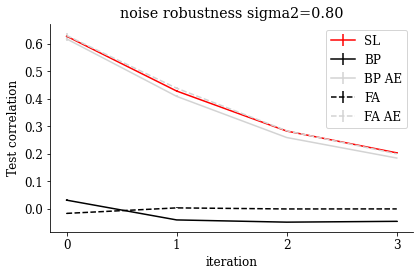

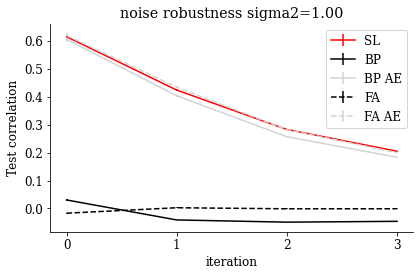

In [84]:
import scipy.stats as ss
 #'BP'#'FA' #'SLVanilla'
facecolors = {'FA':'white', 'SLVanilla':'red', 'BP':'k'}
colors = {'FA':'k', 'BP':'k', 'SLVanilla':'red'}
colors_dd = {'FA':'y', 'BP':'g', }
sigmas = np.unique(master_df['sigma2'])
_, bins = np.histogram(sigmas,5)
sigmas = np.floor(bins*10)/10

for s in sigmas:


    fig, ax = plt.subplots(1,1)
    for method in ['SLVanilla','BP','FA']:


        itr_means, itr_sems = [], []
        for iteration in range(4):
            mehtod_selection = master_df['method']==method
            epsilon_selection = master_df['epsilon']==0.0
            sigma2_selection = (master_df['sigma2']-s)<0.01
            itr = master_df[(mehtod_selection & epsilon_selection )& sigma2_selection]['itr%d'%iteration]
    #         ax.bar(j,itr.mean(), edgecolor=colors[method], color = facecolors[method])
    #         ax.errorbar(j,itr.mean(), ss.sem(itr), color='k' )
            itr_means.append(itr.mean())
            itr_sems.append(ss.sem(itr))
        ax.errorbar(range(4),itr_means, itr_sems, label=method_labels[method], color=colors[method], ls=linestyles[method])
        
        #-----autoencoders
        if method in ['FA','BP']:
            itr_means, itr_sems = [], []
            for iteration in range(4):
                method_selection = master_df_autoencoder['method']==method
                epsilon_selection = master_df_autoencoder['epsilon']==0.0
                sigma2_selection = (master_df_autoencoder['sigma2']-s)<0.01
                itr = master_df_autoencoder[(method_selection & epsilon_selection )& sigma2_selection]['itr%d'%iteration]
        #         ax.bar(j,itr.mean(), edgecolor=colors[method], color = facecolors[method])
        #         ax.errorbar(j,itr.mean(), ss.sem(itr), color='k' )
                itr_means.append(itr.mean())
                itr_sems.append(ss.sem(itr))
            ax.errorbar(range(4),itr_means, itr_sems, label=method_labels[method]+' AE', color=colors_ae[method], ls=linestyles[method])

        
        
        
        
#          #-----dynamic decoders
#         if method in ['FA','BP']:
#             itr_means, itr_sems = [], []
#             for iteration in range(4):
#                 method_selection = master_df_dynamic['method']==method
#                 epsilon_selection = master_df_dynamic['epsilon']==0.0
#                 sigma2_selection = (master_df_dynamic['sigma2']-s)<0.01
#                 itr = master_df_dynamic[(method_selection & epsilon_selection )& sigma2_selection]['itr%d'%iteration]
#         #         ax.bar(j,itr.mean(), edgecolor=colors[method], color = facecolors[method])
#         #         ax.errorbar(j,itr.mean(), ss.sem(itr), color='k' )
#                 itr_means.append(itr.mean())
#                 itr_sems.append(ss.sem(itr))
#             ax.errorbar(range(4),itr_means, itr_sems, label=method_labels[method]+' Dd', color=colors_dd[method], ls=linestyles[method])

        
        
#         if measure_name == 'accuracy':
#             ax.set_ylim([70,100])
#         else:
#             ax.set_ylim([-0.1,0.8])

        ax = plt.gca()
        ax.patch.set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.tick_params(axis='y',direction='out', right=False)
        plt.tick_params(axis='x',direction='out', top=False)
        ax.set_xticks(range(4))
    #     ax.set_xticklabels(range(4))
        ax.set_xlabel('iteration')
        ax.set_ylabel('Test %s'%measure_name)
    #     if measure_name == 'accuracy':
    #         ax.text(1.1, 1, hashname, fontsize=8, rotation=90)

        ax.set_title('noise robustness sigma2=%0.2f'%(s))
        ax.legend()
        plt.tight_layout()

    savedir = path_prefix + '/Results/Symbio/runswithhash/%s/evaluate/'%hashname
    if not os.path.exists(savedir):
        os.makedirs(savedir)
    fig.savefig(savedir + 'noise_sigma2_wAE_%s_%s.png'%(s, measure_name), dpi=200)
    fig.savefig(savedir + 'noise_sigma2_wAE_%s_%s.pdf'%(s, measure_name), dpi=200)
print(hashname, measure_name)

### without autoenooders

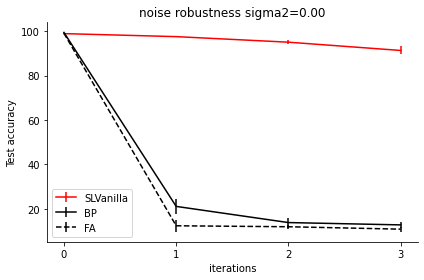

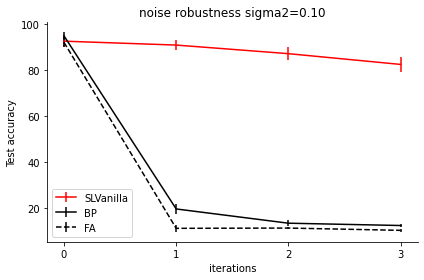

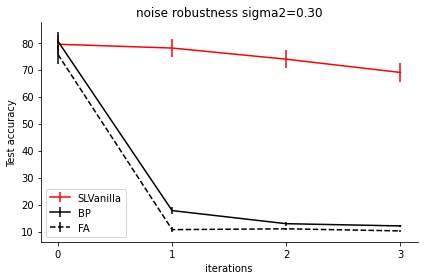

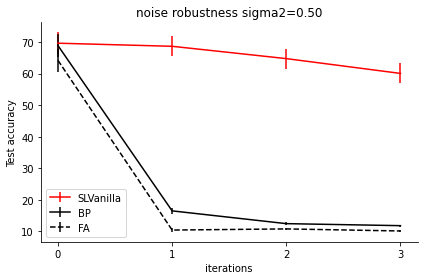

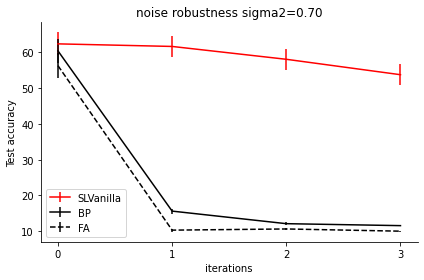

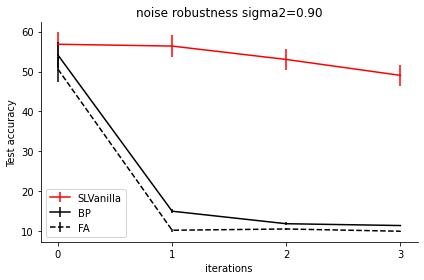

In [99]:
import scipy.stats as ss
 #'BP'#'FA' #'SLVanilla'
facecolors = {'FA':'white', 'SLVanilla':'red', 'BP':'k'}
colors = {'FA':'k', 'BP':'k', 'SLVanilla':'red'}

sigmas = np.unique(master_df['sigma2'])
_, bins = np.histogram(sigmas,5)
sigmas = np.floor(bins*10)/10

for s in sigmas:


    fig, ax = plt.subplots(1,1)
    for method in ['SLVanilla','BP','FA']:


        itr_means, itr_sems = [], []
        for iteration in range(4):
            mehtod_selection = master_df['method']==method
            epsilon_selection = master_df['epsilon']==0.0
            sigma2_selection = (master_df['sigma2']-s)<0.01
            itr = master_df[(mehtod_selection & epsilon_selection )& sigma2_selection]['itr%d'%iteration]
    #         ax.bar(j,itr.mean(), edgecolor=colors[method], color = facecolors[method])
    #         ax.errorbar(j,itr.mean(), ss.sem(itr), color='k' )
            itr_means.append(itr.mean())
            itr_sems.append(ss.sem(itr))
        ax.errorbar(range(4),itr_means, itr_sems, label=method, color=colors[method], ls=linestyles[method])

#         if measure_name == 'accuracy':
#             ax.set_ylim([0,100])
#         else:
#             ax.set_ylim([-0.1,0.8])

        ax = plt.gca()
        ax.patch.set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.tick_params(axis='y',direction='out', right=False)
        plt.tick_params(axis='x',direction='out', top=False)
        ax.set_xticks(range(4))
    #     ax.set_xticklabels(range(4))
        ax.set_xlabel('iterations')
        ax.set_ylabel('Test %s'%measure_name)
    #     if measure_name == 'accuracy':
    #         ax.text(1.1, 1, hashname, fontsize=8, rotation=90)

        ax.set_title('noise robustness sigma2=%0.2f'%(s))
        ax.legend()
        plt.tight_layout()

    savedir = path_prefix + '/Results/Symbio/runswithhash/%s/evaluate/'%hashname
    if not os.path.exists(savedir):
        os.makedirs(savedir)
    fig.savefig(savedir + 'noise_sigma2_%s_%s.png'%(s, measure_name), dpi=200)
    fig.savefig(savedir + 'noise_sigma2_%s_%s.pdf'%(s, measure_name), dpi=200)

## "All we have thus far" curves

/home/tt2684/Research/Results/Symbio/Symbio/Oct02-21-25_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_874/training_results_SLVanilla.csv
/home/tt2684/Research/Results/Symbio/Symbio/Oct02-21-25_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_874/training_results_BP.csv
/home/tt2684/Research/Results/Symbio/Symbio/Oct02-21-25_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_874/training_results_FA.csv
/home/tt2684/Research/Results/Symbio/Symbio/Oct02-21-25_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_829/training_results_SLVanilla.csv
/home/tt2684/Research/Results/Symbio/Symbio/Oct02-21-25_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_829/training_results_BP.csv
/home/tt2684/Research/Results/Symbio/Symbio/Oct02-21-25_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_829/training_results_FA.csv
/home/tt2684/Research/Results/Symbio/Symbio/Oct02-21-26_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_306/training_results_SLVanilla.csv
/home/tt2684/Research/Results/Symbio/Symb

/home/tt2684/Research/Results/Symbio/Symbio/Oct02-21-29_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_278/training_results_FA.csv
/home/tt2684/Research/Results/Symbio/Symbio/Oct02-21-29_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_110/training_results_SLVanilla.csv
/home/tt2684/Research/Results/Symbio/Symbio/Oct02-21-29_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_110/training_results_BP.csv
/home/tt2684/Research/Results/Symbio/Symbio/Oct02-21-29_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_110/training_results_FA.csv
/home/tt2684/Research/Results/Symbio/Symbio/Oct02-21-29_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_889/training_results_SLVanilla.csv
/home/tt2684/Research/Results/Symbio/Symbio/Oct02-21-29_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_889/training_results_BP.csv
/home/tt2684/Research/Results/Symbio/Symbio/Oct02-21-29_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_889/training_results_FA.csv
/home/tt2684/Research/Results/Symbio/Symbio/Oct0

Oct02-21-28_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_319 SLVanilla 98.417
Oct02-21-28_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_319 BP 98.387
Oct02-21-28_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_319 FA 98.287
Oct02-21-28_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_319 SLVanilla 98.417
Oct02-21-28_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_319 BP 98.387
Oct02-21-28_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_319 FA 98.287
Oct02-21-28_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_319 SLVanilla 98.417
Oct02-21-28_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_319 BP 98.387
Oct02-21-28_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_319 FA 98.287
Oct02-21-28_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_827 SLVanilla 98.337
Oct02-21-28_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_827 BP 98.66799999999999
Oct02-21-28_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_827 FA 98.307
Oct02-21-28_MNIST_e6507d0d57_RMSpropRMSpropMNISTF

Oct02-21-29_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_889 SLVanilla 98.34700000000001
Oct02-21-29_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_889 BP 98.65799999999999
Oct02-21-29_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_889 FA 98.478
Oct02-21-29_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_889 SLVanilla 98.34700000000001
Oct02-21-29_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_889 BP 98.65799999999999
Oct02-21-29_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_889 FA 98.478
Oct02-21-29_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_889 SLVanilla 98.34700000000001
Oct02-21-29_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_889 BP 98.65799999999999
Oct02-21-29_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_889 FA 98.478
Oct02-21-30_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_628 SLVanilla 98.508
Oct02-21-30_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE150_628 BP 98.65799999999999
Oct02-21-30_MNIST_e6507d0d57_RMSpropRMSpropMNISTFullyConnE1

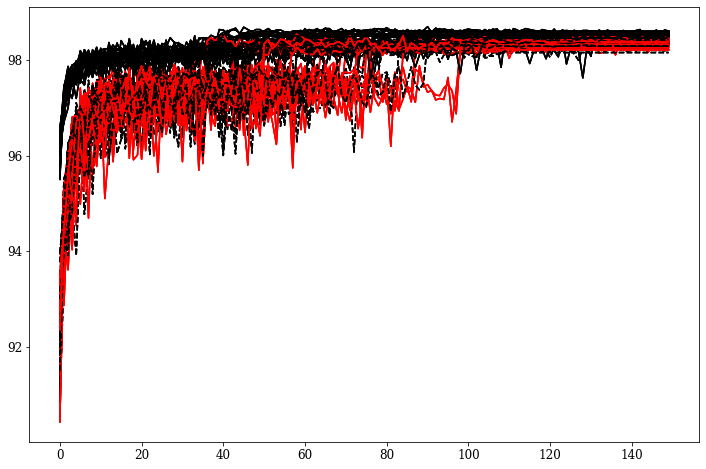

In [46]:
hashname = 'RMSpropRMSpropMNISTFullyConnE150' #'RMSpRMSpFaMNISTAsymResLNet10BNaffPtnc30'
#'RMSpCIFAR10AsymResLNet10BNaff'
#'RMSpRMSpFaMNISTAsymResLNet10BNaffPtnc30' #'RMSpRMSpFaMNISTAsymResLNet10BNaff'
# 'RMSpRMSpMNISTAsymResLNet10BNaffine' 
#'RMSpropRMSpropMNISTAsymResLNet10' #'RMSpropRMSpropMNISTFullyConn' ##'RMSpropRMSpropMNISTFullyConnE150'
methods = ['SLVanilla','BP', 'FA']
colors = {'FA':'k', 'BP':'k', 'SLVanilla':'red'}
linestyles = {'FA':'--', 'BP':'-', 'SLVanilla':'-'}

with open(path_prefix + '/Results/Symbio/runswithhash/%s.txt'%hashname) as f:
    Lines = f.readlines() 

valid_runnames = []
fig, ax = plt.subplots(1,1, figsize=(12,8))
for l in Lines:
    runname = l.strip('\n')
    
    configs = yaml.safe_load(open(path_prefix + '/Results/Symbio/Symbio/%s/configs.yml'%runname, 'r'))
    list_csv_paths = []
    for method in methods:
        p = path_prefix + '/Results/Symbio/Symbio/%s/training_results_%s.csv'%(runname, method)
        if os.path.exists(p):
            print(p)
            df = pd.read_csv(p)
#             if len(list(df['test_acc'])) == configs['epochs']:
            list_csv_paths.append(p)
#     if len(list_csv_paths) == len(methods):
            valid_runnames.append(runname)
        configs = yaml.safe_load(open(path_prefix + '/Results/Symbio/Symbio/%s/configs.yml'%runname, 'r'))

print(len(valid_runnames))

n_epochs = configs['epochs']
arch =  configs['arche'][:-1]

test_init = np.zeros((len(valid_runnames),n_epochs))
test_acc_dict = {}
test_corrd_dict = {}
test_lossd_dict = {}
for method in methods:
    test_acc_dict[method] = copy.deepcopy(test_init)
    test_corrd_dict[method] = copy.deepcopy(test_init)
    test_lossd_dict[method] = copy.deepcopy(test_init)
    
for r, runname in enumerate(valid_runnames):
    configs = yaml.safe_load(open(path_prefix + '/Results/Symbio/Symbio/%s/configs.yml'%runname, 'r'))
    
    for method in methods:
        p = path_prefix + '/Results/Symbio/Symbio/%s/training_results_%s.csv'%(runname, method)
        if os.path.exists(p):
            df = pd.read_csv(p)
            label = method 
            pl = ax.plot(df['test_acc'], label=label, color=colors[method], ls=linestyles[method])
            test_acc_dict[method][r][:len(list(df['test_acc']))] = list(df['test_acc'])
            test_corrd_dict[method][r][:len(list(df['test_acc']))] = list(df['test_corrd'])
            test_lossd_dict[method][r][:len(list(df['test_acc']))] = list(df['test_lossd'])
            
            print(runname, method, max(list(df['test_acc'])))
        

(94.0, 98.0)

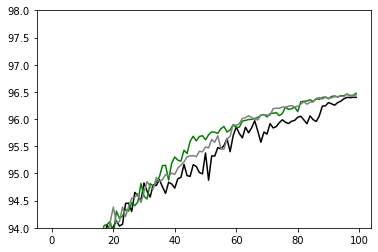

In [66]:
plt.plot(acc_test_dict['BP']/12,'k')
plt.plot(acc_test_dict['SLVanilla']/12,'g')
plt.plot(acc_test_dict['FA']/12,'gray')
plt.ylim([94,98])

[&lt;matplotlib.lines.Line2D at 0x2ae3c47905c0&gt;]

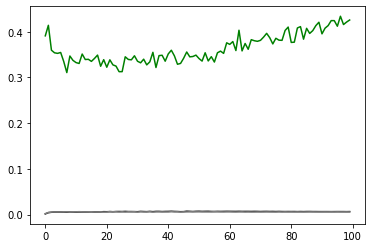

In [71]:
plt.plot(corrd_test_dict['BP']/12,'k')
plt.plot(corrd_test_dict['SLVanilla']/12,'g')
plt.plot(corrd_test_dict['FA']/12,'gray')

(0.0, 40000.0)

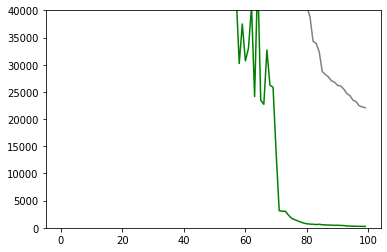

In [77]:
plt.plot(lossd_test_dict['BP']/12,'k')
plt.plot(lossd_test_dict['SLVanilla']/12,'g')
plt.plot(lossd_test_dict['FA']/12,'gray')
plt.ylim([0,40000])


In [53]:
np.mean(results_dict['BP'],0), np.std(results_dict['BP'])

(1133.8692800000001, 40.86001538670293)

In [48]:
np.mean(results_dict['SLVanilla']), np.std(results_dict['SLVanilla'])

(95.61958333333332, 2.040276225511853)

In [49]:
np.mean(results_dict['FA']), np.std(results_dict['FA'])

(95.48608333333333, 1.9930376923318731)

In [99]:
n/3


15.666666666666666

[&lt;matplotlib.lines.Line2D at 0x2ae3c38fd0b8&gt;]

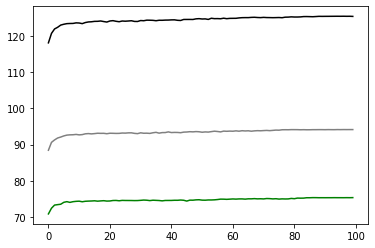

In [100]:
plt.plot(acc_test_dict['BP']/(n/3),'k')
plt.plot(acc_test_dict['SLVanilla']/(n/3),'g')
plt.plot(acc_test_dict['FA']/(n/3),'gray')
# plt.ylim([94,98])

## Generate Figures

In [14]:
runname = 'Apr03-12-13_CIFAR10_9578f81f20_192' #'Apr01-18-30_CIFAR10_eab5f35996_115'

In [17]:
import numpy as np
import pandas as pd
import copy
import os
import json
from utils import helper_functions
import yaml
import scipy.stats as ss
find = helper_functions.find
import matplotlib
matplotlib.use('agg')
import matplotlib.pylab as plt
import pprint 
pp = pprint.PrettyPrinter(indent=4)
import socket
if socket.gethostname()[0:4] in  ['node','holm','wats']:
    path_prefix = '/rigel/issa/users/Tahereh/Research'
elif socket.gethostname() == 'SYNPAI':
    path_prefix = '/hdd6gig/Documents/Research'
elif socket.gethostname()[0:2] == 'ax':
    path_prefix = '/home/tt2684/Research'

class Args:
    config_file = '/home/tt2684/Research/Results/Symbio/Symbio/%s/configs.yml'%runname
    eval_swept_var = ''
    eval_time = 'Now'
    eval_RDMs = False
    


args = Args()

if args.config_file:
    with open(args.config_file, 'r') as stream:
        data = yaml.safe_load(stream)        
#     delattr(args, 'config_file')
    arg_dict = args.__dict__
    for key, value in data.items():
        setattr(args, key, value)
print(args.resultsdir.split('/Research')[1])

if not(hasattr(args, 'databasedir')):
    project = 'Symbio'#'SYY_MNIST'
    arch = 'E%sD%s'%(args.arche, args.archd)
    args.databasedir  = path_prefix+'/Results/database/%s/%s/%s/'%(project,arch,args.dataset)

/Results/Symbio/Symbio/Apr03-12-13_CIFAR10_9578f81f20_192/


['BP', 'FA', 'SLVanilla', 'SLError', 'SLAdvImg', 'SLAdvCost', 'SLConv1', 'SLGrConv1', 'SLLatentRobust']
['BP', 'FA', 'SLVanilla', 'SLError', 'SLAdvImg', 'SLAdvCost', 'SLConv1', 'SLGrConv1', 'SLLatentRobust', 'BPCC0', 'FACC0', 'SLVanillaCC0', 'SLErrorCC0', 'SLAdvImgCC0', 'SLAdvCostCC0', 'SLConv1CC0', 'SLGrConv1CC0', 'SLLatentRobustCC0', 'BPCC1', 'FACC1', 'SLVanillaCC1', 'SLErrorCC1', 'SLAdvImgCC1', 'SLAdvCostCC1', 'SLConv1CC1', 'SLGrConv1CC1', 'SLLatentRobustCC1']
['BP', 'FA', 'SLVanilla', 'SLError', 'SLAdvImg', 'SLAdvCost', 'SLConv1', 'SLGrConv1', 'SLLatentRobust', 'BPCC0', 'FACC0', 'SLVanillaCC0', 'SLErrorCC0', 'SLAdvImgCC0', 'SLAdvCostCC0', 'SLConv1CC0', 'SLGrConv1CC0', 'SLLatentRobustCC0', 'BPCC1', 'FACC1', 'SLVanillaCC1', 'SLErrorCC1', 'SLAdvImgCC1', 'SLAdvCostCC1', 'SLConv1CC1', 'SLGrConv1CC1', 'SLLatentRobustCC1']
/home/tt2684/Research/Results/database/Symbio/EAsymResLNet10FDAsymResLNet10B/CIFAR10/Apr03-12-13_CIFAR10_9578f81f20_192_SLConv1.json was not found
/home/tt2684/Research

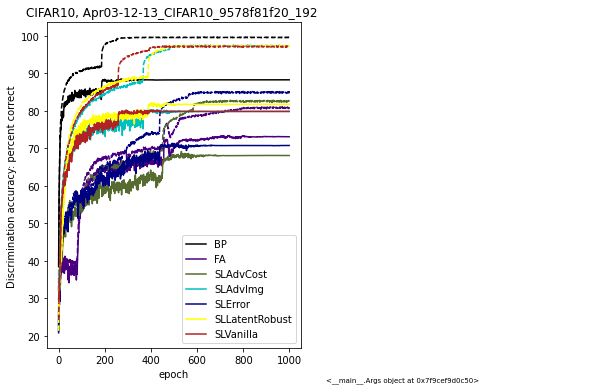

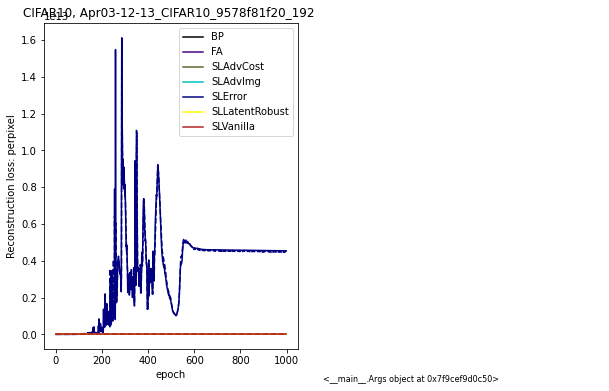

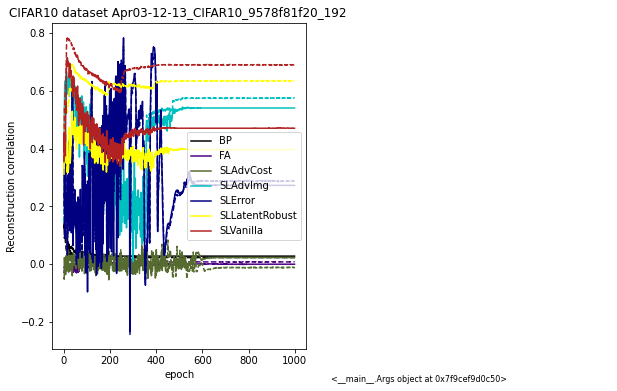

<Figure size 720x432 with 0 Axes>

In [18]:

%matplotlib inline


base_methods = ['BP', 'FA', 'SLVanilla', 'SLError', 'SLAdvImg', 'SLAdvCost','SLConv1', 'SLGrConv1', 'SLLatentRobust']
all_methods = copy.deepcopy(base_methods)

print(base_methods)
[all_methods.extend([m+'CC0'] )for m in base_methods]
[all_methods.extend([m+'CC1'] )for m in base_methods]
print(all_methods)
colors = {'BP':'k', 'FA':'indigo', 'SLVanilla':'firebrick','SLError':'navy', 'SLAdvImg':'c','SLAdvCost':'darkolivegreen','SLLatentRobust':'yellow',
               'BPCC0':'dimgrey', 'FACC0':'blueviolet', 'SLVanillaCC0':'r','SLErrorCC0':'blue', 'SLAdvImgCC0':'c','SLAdvCostCC0':'green','SLLatentRobustCC0':'khaki',
               'BPCC1':'lightgrey', 'FACC1':'mediumpurple', 'SLVanillaCC1':'salmon','SLErrorCC1':'lightsteelblue', 'SLAdvImgCC1':'c','SLAdvCostCC1':'lightgreen','SLLatentRobustCC1':'darkgoldenrod',
               'SLConv1':'sandybrown', 'SLGrConv1':'brown' }
# colors =  {'BP':'k', 'FA':'grey', 'SLVanilla':'r','SLRobust':'salmon',
#             'SLError':'orange', 'SLErrorTemplateGenerator':'yellow', 'BSL':'b','SLGAN':'m'}


methods = all_methods #['BP','FA','SLVanilla','SLGAN' ]#',,'SLRobust', 'SLError''SLRobust', 'SLError' ,'BSL',  'SLErrorTemplateGenerator' 'SLError', 

print(methods)

if args.eval_RDMs:
    RDMs_dict = {}
    layers = ['RDM_conv1_FF', 'RDM_conv1_FB', 'RDM_latents_FF', 'RDM_upsample2',]
    import h5py
    for method in  methods:
        hf = h5py.File(args.resultsdir+'RDMs_%s.h5'%method, 'r')
        
        RDM_list = [np.array(hf.get(layers[0])),
        np.array(hf.get(layers[1])),
        np.array(hf.get(layers[2])),
        np.array(hf.get(layers[3]))]
        RDMs_dict.update({method:RDM_list}) 

if len(args.eval_swept_var):
    if args.eval_swept_var=='sigma2':
        non_swept_var='epsilon'
        non_swept_var_value=0.0
        swept_vars = np.arange(0, 1.1, 0.1).tolist() #[0, 0.2, 0.4, 0.6, 0.8, 1]
    
    print(swept_vars)
    sigma2 = 0.0
    maxitr = 4
    Test_acce = {}
    # epsilons = [0, 0.2, 0.4, 0.6, 0.8, 1]
    existing_methods = []
    for method in  methods:
        Test_acce_arr = np.zeros((4, len(swept_vars)))
        for iv , swept_var in enumerate(swept_vars):
            # json_name = '%s_%s_eval%s_maxitr4_epsilon%0.1e.json'%(args.runname, method, args.eval_time, epsilon)
            if args.eval_swept_var=='sigma2':
                json_name = '%s%s_%s_eval%s_maxitr%d_epsilon%0.1e_noisesigma2%.1f.json'%(args.databasedir,args.runname, method, args.eval_time, maxitr, non_swept_var_value, swept_var)
            else:
                json_name = '%s%s_%s_eval%s_maxitr%d_epsilon%0.1e_noisesigma2%.1f.json'%(args.databasedir,args.runname, method, args.eval_time, maxitr, swept_var, sigma2)
            print(json_name)
            try:
                with open(json_name, 'r') as fp:
                                
                    results = json.load(fp)   
                    Test_acce_arr[:, iv] = results['Test_acce']     
                    Test_acce.update({method:Test_acce_arr})
                existing_methods.append(method)
            except FileNotFoundError:
                continue

else:
    Test_acce = {}
    Train_acce = {}
    Test_lossd = {}
    Train_lossd = {}
    Test_lossl = {}
    Train_lossl = {}
    Test_corrd = {}
    Train_corrd = {}
    Learning_rate = {}
    
    Align_corr_first = {}
    Align_corr_last = {}
    
    Align_ratios_first = {}
    Align_ratios_last = {}
    
    Forward_norm_first = {}
    Forward_norm_last = {}
    
    existing_methods = []
    for method in  methods:
        
        try:
            with open('%s%s_%s.json'%(args.databasedir,args.runname, method), 'r') as fp:
                results = json.load(fp)        
                Test_acce.update({method:results['Test_acce']})
                Train_acce.update({method:results['Train_acce']})

                Test_lossd.update({method:results['Test_lossd']})
                Train_lossd.update({method:results['Train_lossd']})


                Test_lossl.update({method:results['Test_lossl']})
                Train_lossl.update({method:results['Train_lossl']})

                Test_corrd.update({method:results['Test_corrd']})
                Train_corrd.update({method:results['Train_corrd']})
                
                Learning_rate.update({method:results['lrF']})
                
                Align_corr_first.update({method:results['Alignments_corrs_first_layer']})
                Align_corr_last.update({method:results['Alignments_corrs_last_layer']})
                
                Align_ratios_first.update({method:results['Alignments_ratios_first_layer']})
                Align_ratios_last.update({method:results['Alignments_ratios_last_layer']})
                
                Forward_norm_first.update({method:results['Forward_norm_first_layer']})
                Forward_norm_last.update({method:results['Forward_norm_last_layer']})
                              
            existing_methods.append(method)
        except FileNotFoundError:
            print('%s%s_%s.json was not found'%(args.databasedir,args.runname, method))
            continue
                        

existing_methods = np.unique(existing_methods)


# args.resultsdir = args.resultsdir.replace('ConvMNIST_playground', 'SYY2020')
resultsdir = path_prefix + args.resultsdir.split('/Research')[1]
pp.pprint(vars(args))
# I used to save results into numpy files

# list_npy = find( '*.npy', resultsdir )
# print(list_npy)
# print(os.listdir(resultsdir))

# results = {}
# for f in list_npy:
#     print(f[:-4])
#     k = f[:-4].split('_')[0] + '_%s'%f[:-4].split('_')[1]
#     r = np.load(resultsdir + f)
#     results.update({k:r})
# print(results.keys())

if args.eval_RDMs:
    # bar plots
    corrs = [ss.pearsonr(RDMs_dict['BP'][l].ravel(), RDMs_dict['SLVanilla'][l].ravel())[0] for l in range(4)]
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=[5.5,4])
    
    width = 0.35
    dist = width/4

    l=0
    axes.bar([0],1-ss.pearsonr(RDMs_dict['BP'][l].ravel(), RDMs_dict['SLVanilla'][l].ravel())[0],width=width, label='1st layer-forward', color='salmon')
    l=1
    axes.bar([width+dist],1-ss.pearsonr(RDMs_dict['BP'][l].ravel(), RDMs_dict['SLVanilla'][l].ravel())[0],width=width, label='1st layer-feedback',color='r')
    l=2
    axes.bar([0.5+3/2*width+2*dist],1-ss.pearsonr(RDMs_dict['BP'][l].ravel(), RDMs_dict['SLVanilla'][l].ravel())[0],width=width, label='top layer-forward',color='lightblue')
    l=3
    axes.bar([0.5+5/2*width+3*dist],1-ss.pearsonr(RDMs_dict['BP'][l].ravel(), RDMs_dict['SLVanilla'][l].ravel())[0],width=width, label='top layer-feedback',color='b')
    
    mixed_1st_layer_SLVanilla = np.concatenate((RDMs_dict['SLVanilla'][0].ravel(),RDMs_dict['SLVanilla'][1].ravel()))
    mixed_top_layer_SLVanilla = np.concatenate((RDMs_dict['SLVanilla'][2].ravel(),RDMs_dict['SLVanilla'][3].ravel()))

    mixed_1st_layer_BP = np.concatenate((RDMs_dict['BP'][0].ravel(),RDMs_dict['BP'][1].ravel()))
    mixed_top_layer_BP = np.concatenate((RDMs_dict['BP'][2].ravel(),RDMs_dict['BP'][3].ravel()))


    print('SHAPE',mixed_1st_layer_BP.shape)
    axes.bar([1+7/2*width+4*dist],1-ss.pearsonr(mixed_1st_layer_BP, mixed_1st_layer_SLVanilla)[0],width=width, label='1st layer-mixed',color='firebrick')
    axes.bar([1+9/2*width+5*dist],1-ss.pearsonr(mixed_top_layer_BP, mixed_top_layer_SLVanilla)[0],width=width, label='top layer-mixed',color='darkblue')
    
    
    
    axes.legend(loc='upper right')
    axes.set_ylabel('Dissimilarity between RSMs of SL and BP')
    axes.set_xticks([])
    ax = plt.gca()
    ax.patch.set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tick_params(axis='y',direction='out', right=False)
    plt.tick_params(axis='x',direction='out', top=False)
    fig.savefig(args.resultsdir+'Bars_RDMs_comparisons_%s.png'%(args.runname), dpi=200)
    fig.savefig(args.resultsdir+'Bars_RDMs_comparisons_%s.pdf'%(args.runname), dpi=200)
    plt.clf()

    #

    # RDM consistencies
    RDMs_consistencies = np.zeros((len(methods), len(methods), 4))
    for i, methodi in enumerate(methods):
        for j, methodj in enumerate(methods):
            for l in range(4):
                RDMs_consistencies[i, j , l] = ss.pearsonr(RDMs_dict[methodi][l].ravel(), RDMs_dict[methodj][l].ravel())[0]
                print(methodi,methodj,RDMs_consistencies[:,:,l ])
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=[12,4])
    for l in range(4):
        im = axes[l].matshow(RDMs_consistencies[:, : , l], vmin=0, vmax=1, origin='lower', cmap=plt.cm.get_cmap('Spectral_r'))
        axes[l].set_xticks(range(len(methods)))
        axes[l].set_xticklabels(methods)
        if l ==0:
            axes[l].set_yticks(range(len(methods)))
            axes[l].set_yticklabels(methods)
        else:
            axes[l].set_yticks([])

        
        axes[l].set_title(layers[l][4:], y=1.25)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    fig.suptitle('Correlation between RDMs %s, %s'%(args.runname, args.dataset))
    plt.show()
#     fig.savefig(args.resultsdir+'RDMs_comparisons_%s.png'%(args.runname), dpi=200)
#     fig.savefig(args.resultsdir+'RDMs_comparisons_%s.pdf'%(args.runname), dpi=200)
#     plt.clf()

elif len(args.eval_swept_var):
    print(existing_methods)
    #------ accuracy ------------
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=[20,4])

    for itr in range(4):
        for method in existing_methods:
            if itr == 3 :
                axes[itr].plot(swept_vars, Test_acce[method][itr], color=colors[method], label=method)
            else:
                axes[itr].plot(swept_vars, Test_acce[method][itr], color=colors[method])

        axes[itr].set_xlabel(args.eval_swept_var)
        axes[itr].set_ylabel('Discrimination accuracy: percent correct')
        axes[itr].set_title('itr = %d'%itr)
        axes[itr].set_ylim([0,100])
        

        fig.suptitle('%s dataset %s eval%s %s=%s'%(args.dataset, args.runname, args.eval_time, non_swept_var ,non_swept_var_value))

        # axes[1].set_xticks([])
        # axes[1].set_yticks([])
        # axes[1].axis('off')
        # txt= axes[1].text(-0.1,-0.1,str(args),wrap=True, fontsize=8 )
        # txt._get_wrap_line_width = lambda : 200

    axes[3].legend()

#     fig.savefig(resultsdir+'robust_results_eval%s_%s_%s.pdf'%(args.eval_time, non_swept_var,non_swept_var_value), dpi=200)
#     fig.savefig(resultsdir+'robust_results_eval%s_%s_%s.png'%(args.eval_time, non_swept_var,non_swept_var_value), dpi=200)

    plt.clf()


else:

    #------ accuracy ------------
    summary_dic_Train = {}
    summary_dic_Test = {}
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10,6])

    for method in existing_methods:
         
            axes[0].plot(Train_acce[method], color=colors[method], ls='--')
            axes[0].plot(Test_acce[method], color=colors[method], label=method)
        
            print('Train ACC','%s:'%method, Train_acce[method][-1], end =" ")
            print('**')
            print('Test ACC','%s:'%method, Test_acce[method][-1], end =" ")
            print('**')
            summary_dic_Train.update({method: [Train_acce[method][-1], Train_lossd[method][-1], Train_lossl[method][-1],Train_corrd[method][-1], len(Train_acce[method])]})
            summary_dic_Test.update({method: [Test_acce[method][-1], Test_lossd[method][-1], Test_lossl[method][-1],Test_corrd[method][-1], len(Test_acce[method])]})

    df_train = pd.DataFrame.from_dict(summary_dic_Train, orient='index', columns=['Accuracy', 'LossPixel','LossLatent','CorrPixel','Epoch'])
    df_train = df_train.sort_values('Accuracy', ascending=False)

    df_test = pd.DataFrame.from_dict(summary_dic_Test, orient='index', columns=['Accuracy', 'LossPixel','LossLatent','CorrPixel','Epoch'])
    df_test = df_test.sort_values('Accuracy', ascending=False)
    print('*Train*')
    print(df_train)
    print('*Test*')
    print(df_test)
    df_train.to_csv(args.resultsdir+'df_train_%s.csv'%args.runname, sep=',')
    df_test.to_csv(args.resultsdir+'df_test_%s.csv'%args.runname, sep=',')
    # # axes[0].plot(results['SLBP_Train'][:,1],  color='lightgrey', label='SLBP %.2f'%results['SLBP_Test'][0,1])
    # axes[0].plot(results['SLDecoderRobustOutput_Train'][:,1],  color='lightgrey', label='SLDecoderRobustOutput %.2f'%results['SLDecoderRobustOutput_Test'][0,1])

    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('Discrimination accuracy: percent correct')
    axes[0].set_title('%s, %s '%(args.dataset, args.runname))
    axes[0].legend()

    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].axis('off')
    txt= axes[1].text(-0.1,-0.1,str(args),wrap=True, fontsize=7 )
    txt._get_wrap_line_width = lambda : 200


#     fig.savefig(resultsdir+'acc_results_%depochs.pdf'%args.epochs, dpi=200)
#     fig.savefig(resultsdir+'acc_results_%depochs.png'%args.epochs, dpi=200)
#     plt.show()
#     plt.clf()

    #------ reconstruction loss ------------
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10,6])
    
    for method in existing_methods:
        
        axes[0].plot(Train_lossd[method], color=colors[method], ls='--')

        axes[0].plot(Test_lossd[method], color=colors[method], label=method)
  

    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('Reconstruction loss: perpixel')
    axes[0].set_title('%s, %s '%(args.dataset, args.runname))
    axes[0].legend()

    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].axis('off')
    txt= axes[1].text(-0.1,-0.1,str(args),wrap=True, fontsize=8 )
    txt._get_wrap_line_width = lambda : 200


#     fig.savefig(resultsdir+'lossd_results_%depochs.pdf'%args.epochs, dpi=200)
#     fig.savefig(resultsdir+'lossd_results_%depochs.png'%args.epochs, dpi=200)

#     plt.clf()



    #------ reconstruction corr ------------
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10,6])

    for method in existing_methods:


        axes[0].plot(Train_corrd[method], color=colors[method], ls='--')

        axes[0].plot(Test_corrd[method], color=colors[method], label=method)

    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('Reconstruction correlation')
    axes[0].set_title('%s dataset %s '%(args.dataset, args.runname))
    axes[0].legend()

    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].axis('off')
    txt= axes[1].text(-0.1,-0.1,str(args),wrap=True, fontsize=8 )
    txt._get_wrap_line_width = lambda : 200


# #     fig.savefig(resultsdir+'corrd_results_%depochs.pdf'%args.epochs, dpi=200)
# #     fig.savefig(resultsdir+'corrd_results_%depochs.png'%args.epochs, dpi=200)

#     plt.clf()
#     plt.show()

    #------ alignment corr ------------
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10,6])

    for method in existing_methods:


        axes[0].plot(Align_corr_first[method], color=colors[method], ls='--',label=method)

    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('Alignment correlation')
    axes[0].set_title('%s dataset %s '%(args.dataset, args.runname))
    axes[0].legend()

    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].axis('off')
    txt= axes[1].text(-0.1,-0.1,str(args),wrap=True, fontsize=8 )
    txt._get_wrap_line_width = lambda : 200


#     fig.savefig(resultsdir+'corrd_results_%depochs.pdf'%args.epochs, dpi=200)
#     fig.savefig(resultsdir+'corrd_results_%depochs.png'%args.epochs, dpi=200)

    plt.clf()
    plt.show()
    
    


In [19]:
 existing_methods

array(['BP', 'FA', 'SLAdvCost', 'SLAdvImg', 'SLError', 'SLLatentRobust',
       'SLVanilla'], dtype='<U14')

Text(0.5, 0.92, 'CIFAR10 dataset Apr03-12-13_CIFAR10_9578f81f20_192 ')

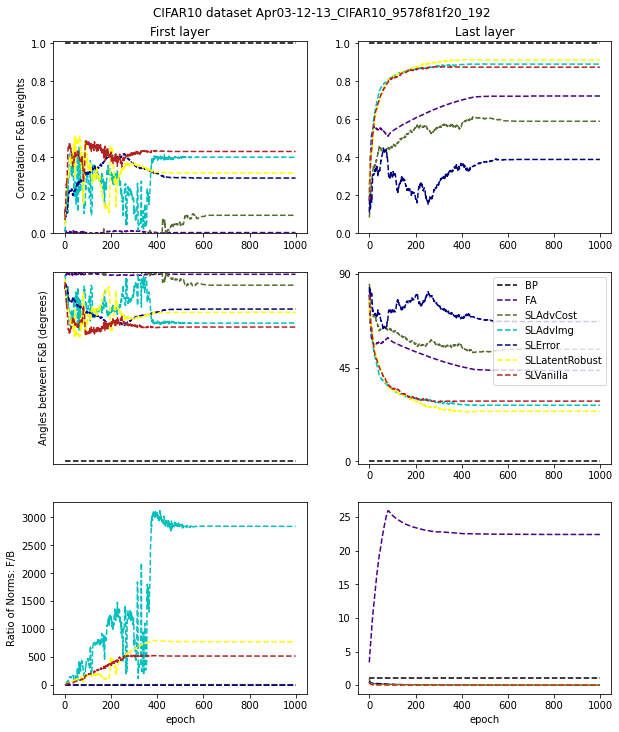

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=[10,12])

for method in existing_methods:


    axes[0,0].plot(Align_corr_first[method], color=colors[method], ls='--',label=method)
    axes[0,1].plot(Align_corr_last[method], color=colors[method], ls='--',label=method)
    
    axes[1,0].plot(180*np.arccos(np.array(Align_corr_first[method]))/np.pi, color=colors[method], ls='--',label=method)
    axes[1,1].plot(180*np.arccos(np.array(Align_corr_last[method]))/np.pi, color=colors[method], ls='--',label=method)

    axes[2,0].plot(Align_ratios_first[method], color=colors[method], ls='--',label=method)
    axes[2,1].plot(Align_ratios_last[method], color=colors[method], ls='--',label=method)



axes[0,0].set_ylabel('Correlation F&B weights')
axes[1,0].set_ylabel('Angles between F&B (degrees)')
axes[2,0].set_ylabel('Ratio of Norms: F/B')

axes[0,0].set_ylim([0,1.01])
axes[0,1].set_ylim([0,1.01])
axes[1,0].set_ylim([-1,91])
axes[1,1].set_ylim([-1,91])

axes[1,0].set_yticks([0,45,90])
axes[1,1].set_yticks([0,45,90])

axes[1,1].legend()

axes[2,0].set_xlabel('epoch')
axes[2,1].set_xlabel('epoch')

axes[0,0].set_title('First layer')
axes[0,1].set_title('Last layer')

axes[1,0].set_xticks([])
axes[1,0].set_yticks([])
# axes[1,0].axis('off')
# txt= axes[1,0].text(-0.1,-0.1,str(args),wrap=True, fontsize=8 )
# txt._get_wrap_line_width = lambda : 200
fig.suptitle('%s dataset %s '%(args.dataset, args.runname), y=0.92)

#     fig.savefig(resultsdir+'Alignment_results_%depochs.pdf'%args.epochs, dpi=200)
#     fig.savefig(resultsdir+'Alignment_results_%depochs.png'%args.epochs, dpi=200)



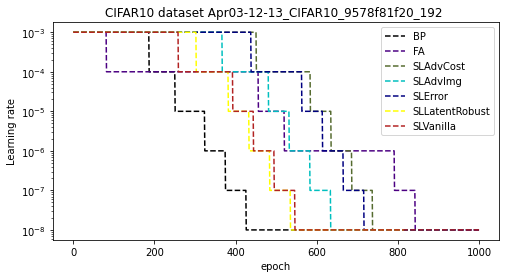

In [105]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=[8,4])

for method in existing_methods:

    axes.plot(Learning_rate[method], color=colors[method], ls='--',label=method)
    
axes.set_yscale('log')

axes.set_xlabel('epoch')
axes.set_ylabel('Learning rate')
axes.set_title('%s dataset %s '%(args.dataset, args.runname))
axes.legend()



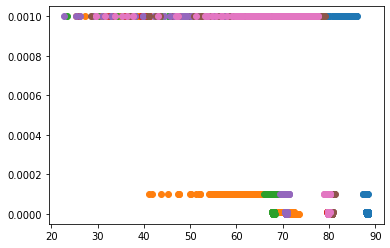

In [106]:
for method in existing_methods:
    plt.scatter(Test_acce[method],Learning_rate[method])
    ss.pearsonr(Test_acce[method],Learning_rate[method])

In [108]:
method='SLAdvImg'
print(ss.pearsonr(Test_acce[method],Learning_rate[method]))
print(ss.pearsonr(Test_corrd[method],Learning_rate[method]))

(-0.5944014199492644, 5.7736479588211e-91)
(-0.6651103048858464, 3.1688250041556924e-121)
